## **Import Library**
Melakukan import library yang diperlukan untuk membuat model 

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile,os, random, cv2, PIL, pathlib
from tensorflow.python import metrics
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

## **Dataset Preparation**
Memanggil dataset yang ada dalam kaggle. Saya menggunakan dataset Shoe-vs-sandal-vs-boot-dataset-15k-images.
https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

Dataset diatas berisi 3 varian alas kaki yang dibagi menjadi 3 folder. Setiap varian berisi 5000 data gambar yang akan digunakan untuk train model dengan total data 15000 gambar. Varian dari dataset ini sesuai judulnya adalah Shoe, Sandal, dan Boot.  

In [2]:
! pip install kaggle
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! kaggle datasets download muratkokludataset/pistachio-image-dataset

100% 26.7M/26.7M [00:02<00:00, 21.5MB/s]
100% 26.7M/26.7M [00:02<00:00, 12.3MB/s]


In [4]:
! unzip pistachio-image-dataset.zip

Archive:  pistachio-image-dataset.zip
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.arff  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xls  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xlsx  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset_Citation_Request.txt  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.arff  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.xls  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.xlsx  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset_Citation_Request.txt  
  inflating: Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg  
  i

## **Split Dataset**
Dataset dibagi dalam 3 rasio : 
<br>train dataset : 80% = 12000 data
<br>validation dataset : 10% = 1500 data
<br>test dataset : 10% = 1500 data

In [5]:
! pip install split-folders
import splitfolders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
basedirect = "Pistachio_Image_Dataset/Pistachio_Image_Dataset"
base_ds = pathlib.Path(basedirect)

splitfolders.ratio(
    basedirect, 
    output = "imgs", 
    seed = 123, 
    ratio = (.8,.2), 
    group_prefix = None
)

Copying files: 2148 files [00:00, 8349.15 files/s]


## Image Labelling
Pada bagian ini digunakan untuk proses pemberian label pada dataset

In [7]:
pistachio_label = ["Kirmizi_Pistachio","Siirt_Pistachio"]

kirmizi = [fn for fn in os.listdir(f'{basedirect}/Kirmizi_Pistachio') if fn.endswith('.jpg')]
siirt = [fn for fn in os.listdir(f'{basedirect}/Siirt_Pistachio') if fn.endswith('.jpg')]
pistachio = [kirmizi,siirt]

## Dataset Visualitation
Selanjutnya diperlukan untuk melakukan visualisasi data supaya dapat lebih memahami dataset yang akan digunakan

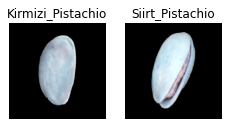

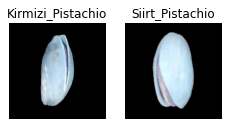

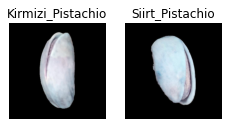

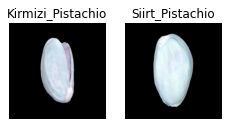

In [8]:
for i in range (4):
  plt.figure(figsize=(10,10))
  for i in range(len(pistachio_label)):
    plt.subplot(1, 5, i+1)
    file = random.choice(os.listdir(basedirect + "/" + pistachio_label[i]))
    image_path = os.path.join(basedirect + "/" + pistachio_label[i], file)
    img = cv2.imread(image_path)
    plt.title(pistachio_label[i])
    plt.imshow(img)
    plt.axis("off")
    plt.grid(None)

In [9]:
train_dir = os.path.join(basedirect,'imgs/train')
val_dir = os.path.join(basedirect,'imgs/val')

##Augmentasi Gambar 
Pada proses ini akan dilakukan augmentasi gambar yang memiliki fungsi untuk meningkatkan ukuran kumpulan data gambar secara artifiisial hal ini dapat dicapai dengan menerapkan transformasi aca ke dalam gambar.

In [10]:
train_datagen = ImageDataGenerator(
      rescale = 1.0/255,
      horizontal_flip = True,
      shear_range = 0.2,
      zoom_range = 0.2, 
      rotation_range = 20,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      vertical_flip = False,
      fill_mode = 'nearest',
      validation_split = 0.2)

validation_datagen = ImageDataGenerator(
    rescale = 1.0/255


)

## FLow Train Set Data dan Validation Set Data

Proses load data ke dalam memori 

In [11]:
train_set = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (175, 175),
    batch_size = 32,
    class_mode='categorical'
)

val_set = validation_datagen.flow_from_directory(
    'imgs/val',
    target_size = (175, 175),
    batch_size = 32,
    class_mode='categorical',
)



Found 1717 images belonging to 2 classes.
Found 431 images belonging to 2 classes.


## Modelling
Proyek ini menggunakan metode Conv2D Maxpool LayerConv2D Layer untuk melakukan permodelan

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation= 'relu',input_shape=(175,175,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation= 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation= 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation= 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation= 'relu'),
    tf.keras.layers.Dense(2,activation= 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 173, 173, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

## Compile Model
Setelah layer telah terbangun, maka akan dicompile menggunakan optimizer adam dengan loss categorical_crossentropy dan menggunakan metrik accuracy

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

## Callback
Pada bagian ini akan digunakan fungsi callback yang berfungsi untuk menghentikan proses pelatihan data ketika sudah mencapai kondisi yang telah ditentukan

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.98):
      print("\nAkurasi sudah diatas 98%, Bagus!")
      self.model.stop_training = True

callbacks = myCallback()

## Proses Training Model
Setelah melakukan beberapa proses diatas, maka akan dilakukan training model dengan memanggil fungsi fit. Serta pada training model ini, akan digunakan juga fungsi callback yang telah dibangun sebelumnya

In [15]:
history = model.fit(train_set, 
                    epochs = 55, 
                    steps_per_epoch = 50,
                    validation_data = val_set, 
                    validation_steps = 10,
                    verbose = 2,
                    callbacks = callbacks)

Epoch 1/55
50/50 - 28s - loss: 0.6912 - accuracy: 0.5802 - val_loss: 0.6754 - val_accuracy: 0.4563 - 28s/epoch - 563ms/step
Epoch 2/55
50/50 - 17s - loss: 0.6371 - accuracy: 0.6318 - val_loss: 0.5631 - val_accuracy: 0.7094 - 17s/epoch - 345ms/step
Epoch 3/55
50/50 - 18s - loss: 0.6191 - accuracy: 0.6526 - val_loss: 0.5317 - val_accuracy: 0.7875 - 18s/epoch - 352ms/step
Epoch 4/55
50/50 - 18s - loss: 0.6006 - accuracy: 0.6721 - val_loss: 0.5435 - val_accuracy: 0.7281 - 18s/epoch - 354ms/step
Epoch 5/55
50/50 - 17s - loss: 0.6001 - accuracy: 0.6734 - val_loss: 0.5156 - val_accuracy: 0.7375 - 17s/epoch - 347ms/step
Epoch 6/55
50/50 - 17s - loss: 0.5866 - accuracy: 0.6885 - val_loss: 0.5474 - val_accuracy: 0.7688 - 17s/epoch - 347ms/step
Epoch 7/55
50/50 - 17s - loss: 0.5939 - accuracy: 0.6904 - val_loss: 0.5080 - val_accuracy: 0.8531 - 17s/epoch - 347ms/step
Epoch 8/55
50/50 - 17s - loss: 0.5837 - accuracy: 0.6740 - val_loss: 0.5050 - val_accuracy: 0.8000 - 17s/epoch - 344ms/step
Epoch 9/

## Grafik Akurasi 
Berikut merupakan grafik akurasi hasil dari training base model

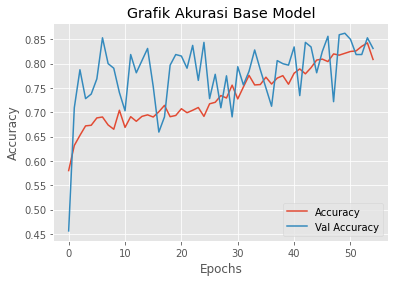

In [20]:
plt.style.use('ggplot')
plt.title("Grafik Akurasi Base Model")
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Grafik Plot Loss
Berikut merupakan grafik loss hasil dari training base model

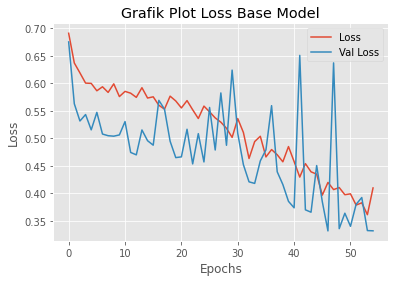

In [21]:
plt.style.use('ggplot')
plt.title("Grafik Plot Loss Base Model")
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Implementasi VGG16

In [16]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(175, 175, 3))
vgg16.trainable = False
inputs = tf.keras.Input((175, 175, 3))
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58889256/58889256 [==============================] - 4s 0us/step


In [17]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 15,242,050
Trainable params: 527,362
Non-trainable params: 14,714,688
___________________________________________

In [18]:
checkpointer = ModelCheckpoint(
    filepath='model/model_vgg16.hdf5', 
    monitor='val_accuracy', 
    mode='max',
    verbose=2, 
    save_best_only=True
)

callbacks=[checkpointer]

In [19]:
history2 = model_vgg16.fit(
    train_set, 
    epochs = 20,
    validation_data = val_set, 
    callbacks = callbacks
)

Epoch 1/20
54/54 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.6704
Epoch 1: val_accuracy improved from -inf to 0.70998, saving model to model/model_vgg16.hdf5
54/54 [==============================] - 26s 430ms/step - loss: 0.6045 - accuracy: 0.6704 - val_loss: 0.4843 - val_accuracy: 0.7100
Epoch 2/20
54/54 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.7484
Epoch 2: val_accuracy improved from 0.70998 to 0.83295, saving model to model/model_vgg16.hdf5
54/54 [==============================] - 20s 379ms/step - loss: 0.5070 - accuracy: 0.7484 - val_loss: 0.3794 - val_accuracy: 0.8329
Epoch 3/20
54/54 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.7833
Epoch 3: val_accuracy improved from 0.83295 to 0.87471, saving model to model/model_vgg16.hdf5
54/54 [==============================] - 21s 379ms/step - loss: 0.4688 - accuracy: 0.7833 - val_loss: 0.3325 - val_accuracy: 0.8747
Epoch 4/20
54/54 [======================

## Grafik Akurasi VGG16
Berikut merupakan grafik akurasi hasil dari training VGG16

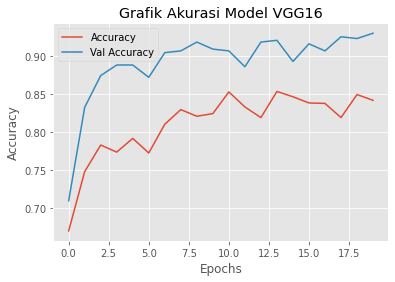

In [22]:
plt.style.use('ggplot')
plt.title("Grafik Akurasi Model VGG16")
plt.plot(history2.history['accuracy'], label = 'Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Grafik Plot Loss
Berikut merupakan grafik loss hasil dari training VGG16

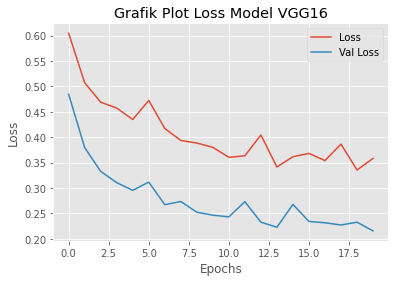

In [23]:
plt.style.use('ggplot')
plt.title("Grafik Plot Loss Model VGG16")
plt.plot(history2.history['loss'], label = 'Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()